# Practical 2

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

Please use the dataset loading code provided below.

** Tasks 1.1: Dataset Exploration **
- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the predictors?
- Visualize the 10 first samples of the dataset
- Visualize the variance of each predictor.


In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

file = 'data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

In [52]:
print('Sample count: {}'.format(len(X_all)))
feature_count = len(X_all[0])
print('Feature count: {}'.format(feature_count))
labels = set(df['class'])
print('Labels: #{} : {}'.format(len(labels), labels))
print('Total value range over all predictors: [{:.4f}, {:.4f}]'.format(X_all.min(),X_all.max()))

Sample count: 105
Feature count: 64
Labels: #8 : {'t-SC-s', 't-CS-s', 'c-CS-s', 't-CS-m', 'c-CS-m', 't-SC-m', 'c-SC-s', 'c-SC-m'}
Total value range over all predictors: [0.0607, 7.4641]


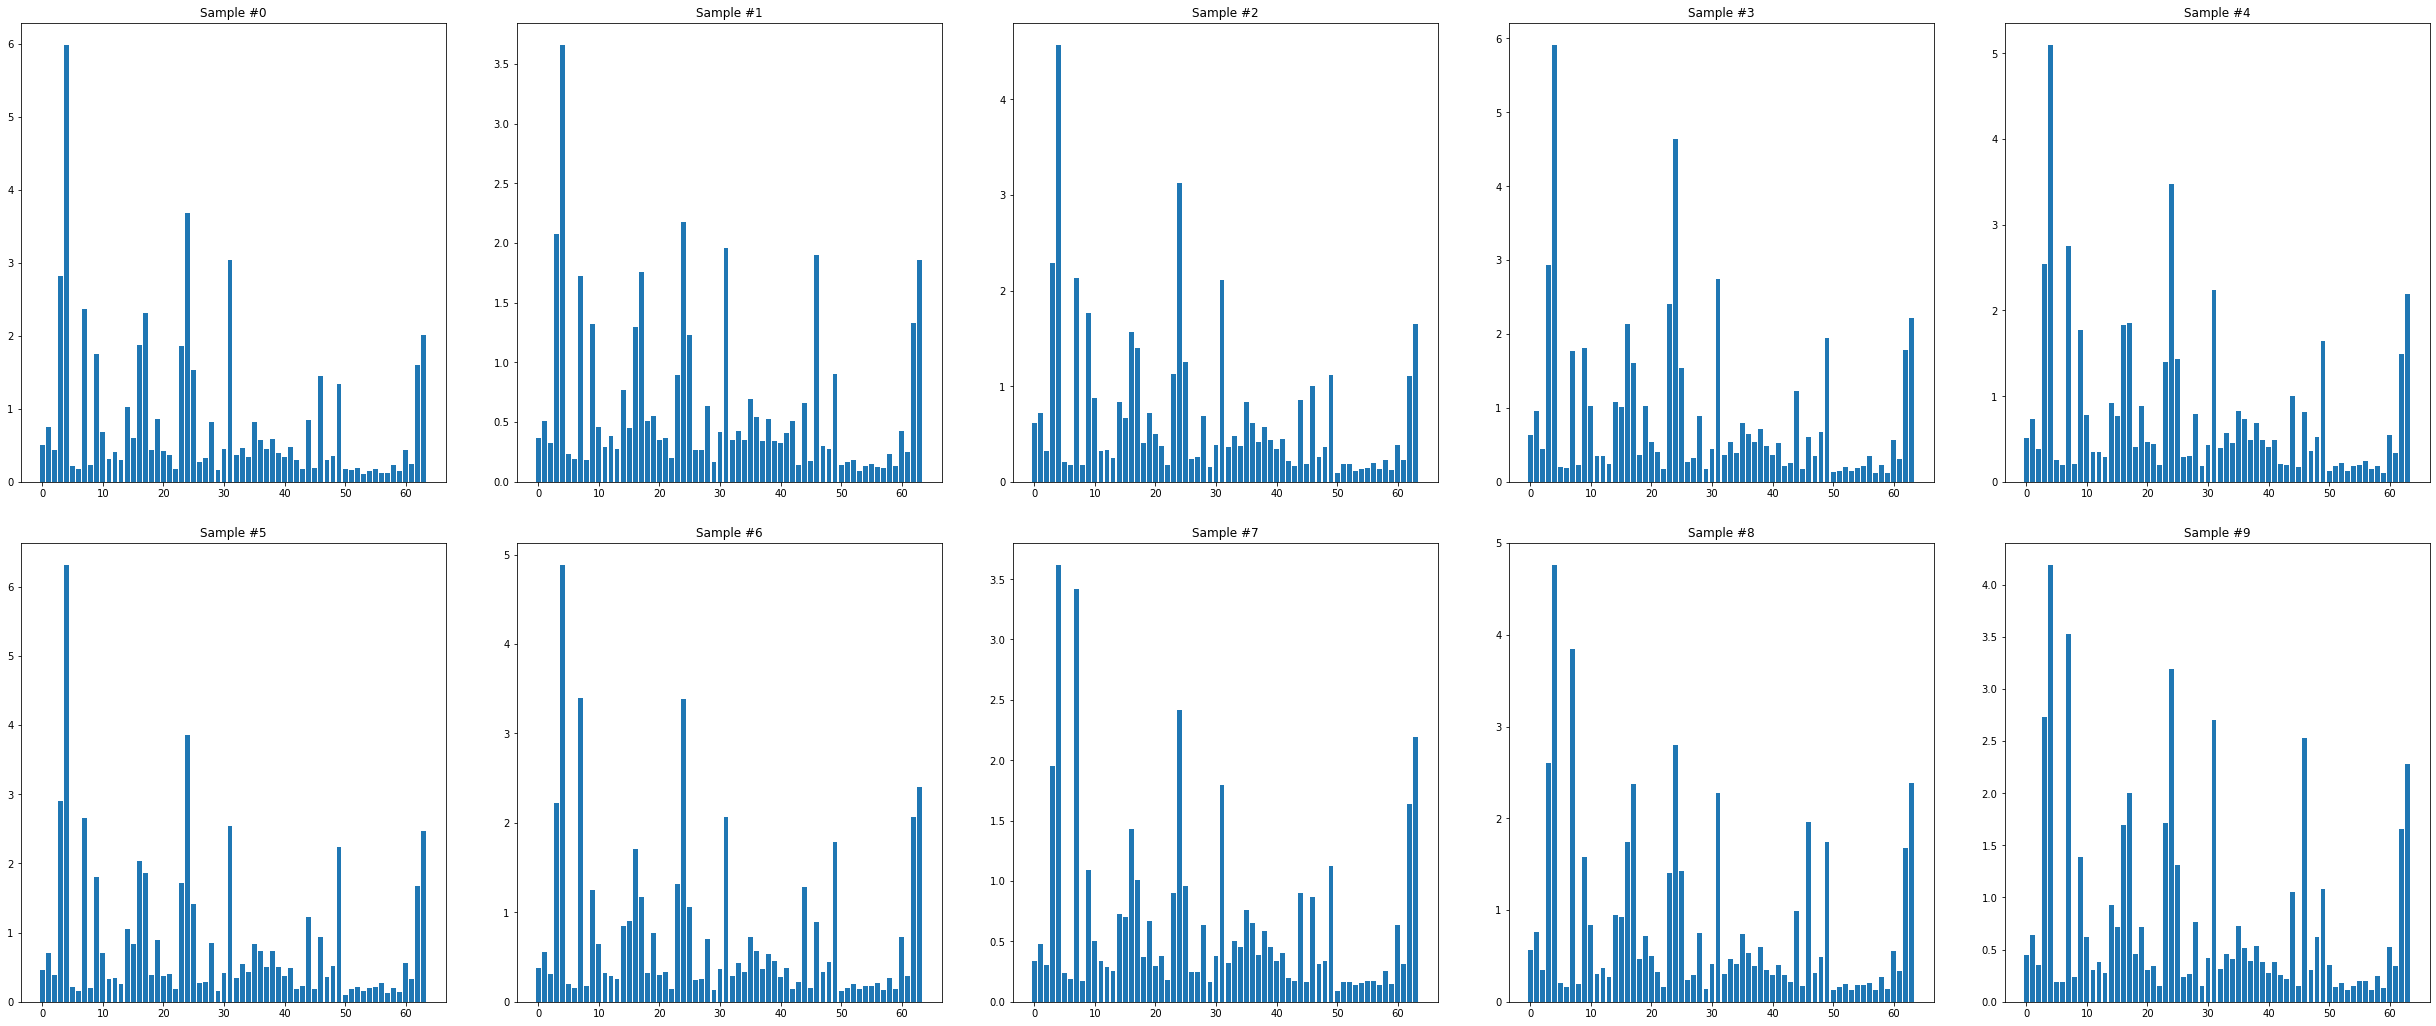

In [53]:
# first 10 samples visual
rows, cols = (2, 5)
fig, ax = plt.subplots(rows, cols, figsize=(35, 15))
fig.tight_layout(pad=4.0)
for i in range(rows*cols):
    ax[i//cols, i%cols].bar(range(feature_count), X_all[i])
    ax[i//cols, i%cols].set_title('Sample #' + str(i))

Text(0.5, 1.0, 'Variance of predictors')

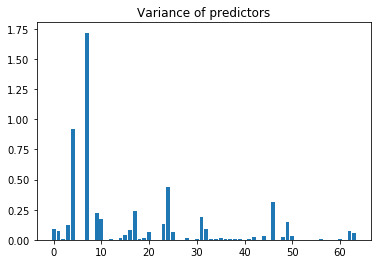

In [54]:
# feature variance visual
plt.bar(range(feature_count), [np.var(X_all[:,i]) for i in range(feature_count)])
plt.title('Variance of predictors')

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, max_samples, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X, y)` which zero-centers your data and sets variance to one.

In [55]:
# returns (xtrain, ytrain, xtest, ytest)

def split_data(X, y, frac=0.3, max_samples=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    assert len(X) == len(y)
    
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    
    if isinstance(max_samples, int):
        X = X[:max_samples]
        y = y[:max_samples]
        
    cut = int(frac*len(X))
    return X[cut:], y[cut:], X[:cut], y[:cut]

In [56]:
# zero mean, unit variance --- standard preprocessing via sklearn
from sklearn import preprocessing
def preprocess(X, y):
    return preprocessing.scale(X)

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

** Task 2.1 ***

1. Implement a function `compute_lda_weights(x, y)`, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

Text(0.5, 0, 'predictors')

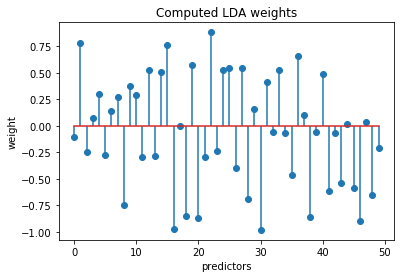

In [57]:
# X, X_test, t, t_test = split_data(X_all, t_all, seed=1)
# m0, m1, mdiff, w_lda = compute_lda_weights(X, t)

w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

In [65]:
def compute_lda_weights(x, y):
    #x = preprocess(x, y)
    
    c1 = x[np.where(y == True)]
    c2 = x[np.where(y == False)]

    c1m = np.matrix(c1.mean(axis=0)).T
    c2m = np.matrix(c2.mean(axis=0)).T
    
    #print(c1[0].shape)
    #print(c1m.shape)
    
    s_w = np.zeros((feature_count,feature_count))
    for i in range(len(c1)):
        el = np.matrix(c1[i]).T
        #print('el {}'.format(el.shape))
        #print('mu {}'.format(c1m.shape))
        s_w += np.dot((el-c1m),(el-c1m).T)
        #print(s_w)
    for i in range(len(c2)):
        el = np.matrix(c2[i]).T
        s_w += np.dot((el-c2m),(el-c2m).T)
    
    
    s_w_inv = np.linalg.inv(s_w)
    w = np.dot(s_w_inv, c1m - c2m),
    
    return c1m, c2m, c1m-c2m, np.array(w[0])

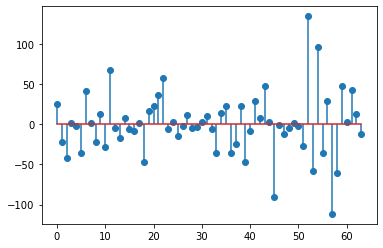

In [70]:
x_train, y_train, x_test, y_test = split_data(X_all, t_all, seed=3)
c1m, c2m, cdiff, w = compute_lda_weights(x_train, y_train)

plt.stem(w, use_line_collection=True)
plt.show()

** Task 2.3 **

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

threshold is -10.455691236874479
Train errors: 0
Test errors: 3


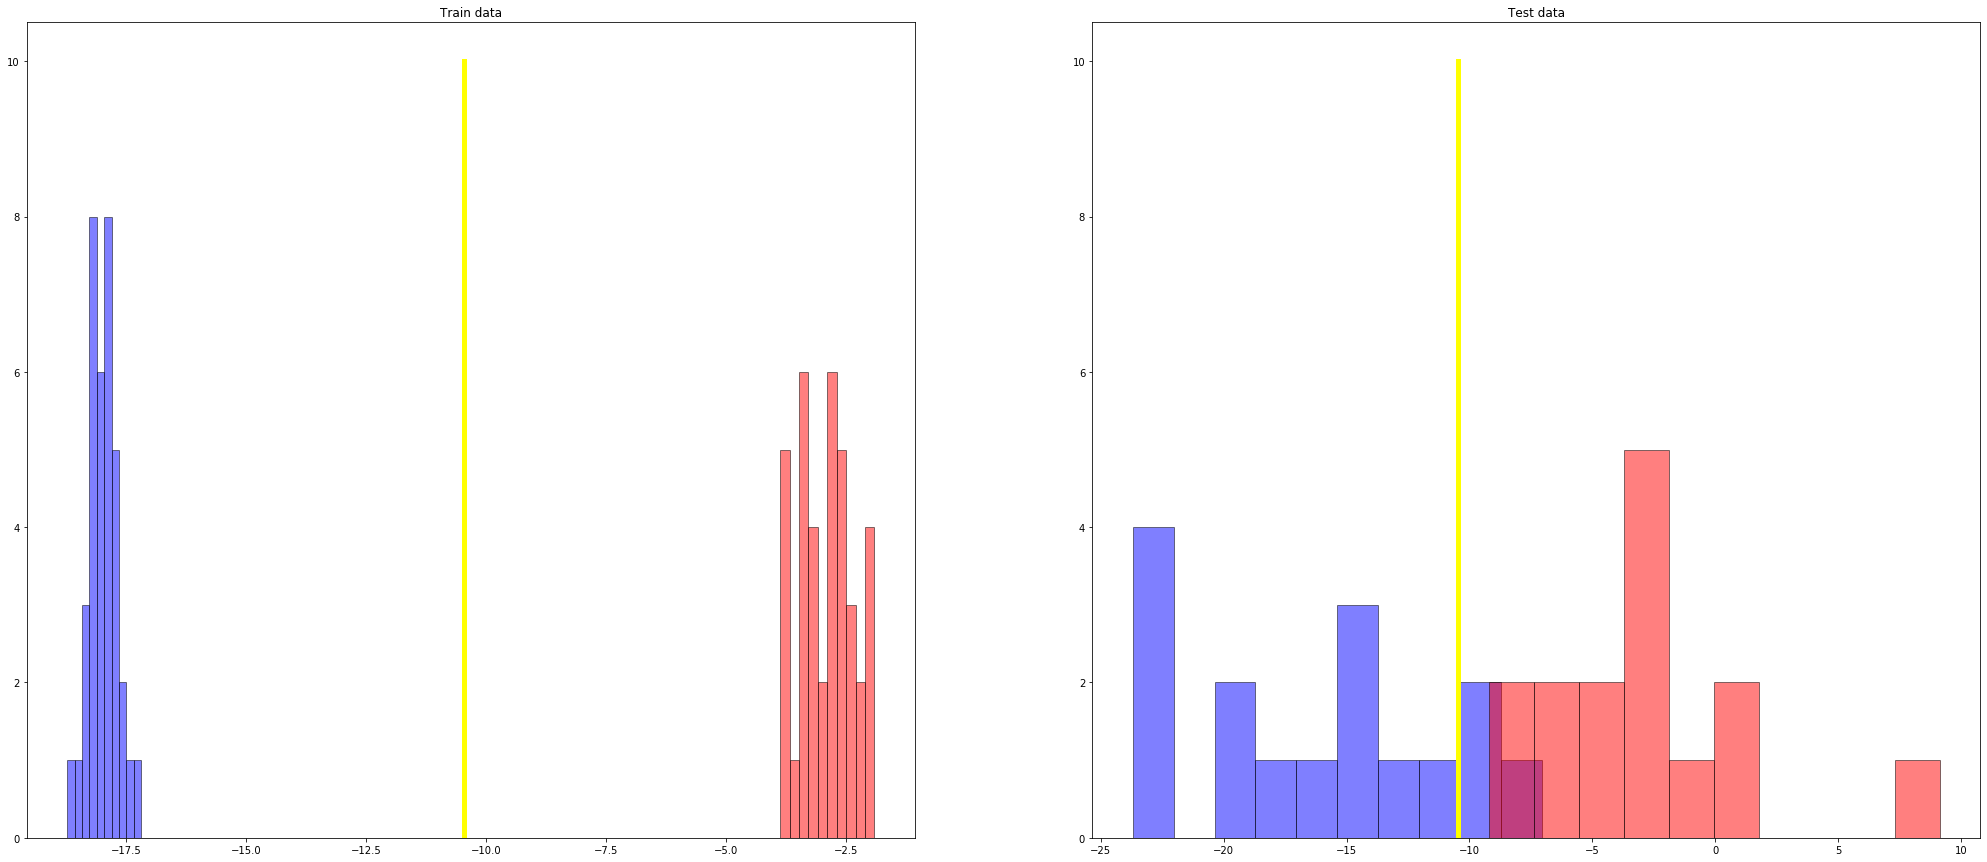

In [73]:
#a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data
#plt.title('Training data projection')
#_ = plt.hist(a,label='class 0',alpha=0.5)
#_ = plt.hist(b,label='class 1',alpha=0.5)

fig, ax = plt.subplots(1,2, figsize=(35, 15))

# train
res_train = np.dot(x_train, w)
c1_l = [res_train[i][0] for i in range(len(y_train)) if y_train[i]]
c2_l = [res_train[i][0] for i in range(len(y_train)) if not y_train[i]]
ax[0].set_title('Train data')
_ = ax[0].hist(c2_l, label='Train: class 2', color='blue', alpha=0.5, edgecolor='black')
_ = ax[0].hist(c1_l, label='Train: class 1', color='red', alpha=0.5, edgecolor='black')

# test
res_test = np.dot(x_test, w)
c1_l = [res_test[i][0] for i in range(len(y_test)) if y_test[i]]
c2_l = [res_test[i][0] for i in range(len(y_test)) if not y_test[i]]
ax[1].set_title('Test data')
_ = ax[1].hist(c2_l, label='Test: class 2', color='blue', alpha=0.5, edgecolor='black')
_ = ax[1].hist(c1_l, label='Test: class 1', color='red', alpha=0.5, edgecolor='black')


# The separation is good, but varies depending on the chosen RNG seed.
# There is a clear difference between train & test data:
# While there is a huge gap inbetween classes on the train data,
#   there is no gap, but overlap on the test data.
# -> Indicates overfitting


# 2.4
thresh = np.dot(w.T, 0.5 * (c1m + c2m))[0,0]
print('threshold is ' + str(thresh))
_ = ax[0].plot([thresh, thresh], [0, 10], color='yellow', linestyle='-', linewidth=5)
_ = ax[1].plot([thresh, thresh], [0, 10], color='yellow', linestyle='-', linewidth=5)

print('Train errors: ' + str(sum([1 for i in range(len(y_train)) if y_train[i] != (res_train[i] >= thresh)])))
print('Test errors: ' + str(sum([1 for i in range(len(y_test)) if y_test[i] != (res_test[i] >= thresh)])))


** Task 2.4 **

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors on both datasets and print them. 

##### Task 2.4
See 2.3 code block above

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. Below, you find all imports that are necessary.


In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression

**Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training error. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
Where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.
2. Apply the IRLS algorithm on data and compute a test error (see the code below).
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?
4. Use the `preprocess` function defined earlier to normalize the data.

**Task 3.2: Logistic Regression with Regularization**

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [27]:
from matplotlib import pyplot as plt

### Task 3.3: Arryhtymia and Ionosphere Dataset

Next, let's run your code on the datasets from openml below.

1. First, explore the dataset. Which differences to ionosphere do you encounter?   
2. Run your IRLS implementation on unprocessed data and preprocessed data. Does it work? If not, why?
3. Compare with sklearn Logistic Regression.

In [29]:
from sklearn.datasets import fetch_openml
X_arr, t_arr = fetch_openml('arrhythmia', version=1, return_X_y=True)
X_arr = np.nan_to_num(X_arr)[:, :25]
t_arr = np.array([1 if l == '1' else 0 for l in t_arr])

X_ion, t_ion = fetch_openml('ionosphere', version=1, return_X_y=True)
t_ion = np.array([1 if l == 'g' else 0 for l in t_ion])
